<a href="https://colab.research.google.com/github/siva-sankar-a/eva/blob/master/S9/EVA4_Session_9_DA_and_GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S9 _Assignment 9_

  | Summary of overall targets |  |
  | - | - |
  | _Dataset_| **CIFAR10** |
  | _Max. number of epochs_| **NA** |
  | _Max. number of parameters_| **NA** |
  | _Architecture_| **Resnet18** |
  | _Target accurracy_| **87%** |


# Implementation

## Initialization

### Mounting google drive to save results

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install torchsummary
!pip install torchviz
!pip install albumentations

     |████████████████████████████████| 51kB 3.4MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=092fbb17bf12164b247114337b4c24d9c7a07d7f2db00314166642367878d7e5
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz
     |████████████████████████████████| 634kB 3.5MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=d78f4af3f6f2d1525cfdaf0e1d378b0ec2083718f4009ddb07cf48f4098eb927
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [4]:
import glob
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
import torch
import torchvision
import numpy as np

from torch.nn import functional as F
import cv2

In [13]:
!rm -rf eva
!git clone "https://github.com/siva-sankar-a/eva.git"

Cloning into 'eva'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 295 (delta 0), reused 1 (delta 0), pack-reused 291
Receiving objects: 100% (295/295), 4.55 MiB | 17.92 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [42]:
%load_ext autoreload
%autoreload 2
from eva.S9.api import Experiment
from eva.S9.data_manager import  DataManager
from eva.S9.viz import viz_cifar10_grid
from eva.S9.utils import textual_summary_cifar10, graphical_summary_cifar10
from eva.S9.settings import cifar10_classes
from eva.S9.model import ResNet, ResNet18

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create an instance of experiment class

In [15]:
experiment = Experiment(name=f'default', dataset_name='cifar10')

CUDA status: True
Files already downloaded and verified
Files already downloaded and verified


### Current transformations 

```
self.train_transforms = transforms.Compose([
transforms.RandomRotation(15),
transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))])
```

In [0]:
from torchvision import datasets

In [0]:
class CIFAR10_dataset(datasets.CIFAR10):
  """
  Custom class to include albumentations data augmentations
  """

  def __init__(self, **kwargs):
    """
    Constructor for custom CIFAR10 dataset
    """
    super().__init__(**kwargs)
  
  def __getitem__(self, index):
    """
    Args:
        index (int): Index

    Returns:
        tuple: (image, target) where target is index of the target class.
    """
    img, target = self.data[index], self.targets[index]

    # doing this so that it is consistent with all other datasets
    if self.transform:
      augmented = self.transform(image=img)
      img = augmented['image']

    if self.target_transform is not None:
      target = self.target_transform(target)

    return img, target

In [0]:
from albumentations import Compose, Rotate, HorizontalFlip, Normalize, RandomSizedCrop
from albumentations.pytorch import ToTensor

In [0]:
train_transforms = Compose([
    Rotate(limit=15), 
    RandomSizedCrop(min_max_height=(20, 32), height=32, width=32),
    HorizontalFlip(),
    Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2471, 0.2435, 0.2616],
    ),
    ToTensor()
])

test_transforms = Compose([
    Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2471, 0.2435, 0.2616],
    ),
    ToTensor()
])

In [21]:
trainset = CIFAR10_dataset(root='./data', train=True, download=True, transform=train_transforms)
testset = CIFAR10_dataset(root='./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
data_manager = DataManager(trainset=trainset, testset=testset)

In [0]:
experiment.data_manager = data_manager

In [0]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [0]:
# get some random training images
dataiter = iter(data_manager.train_loader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


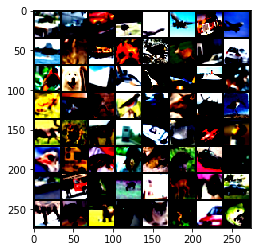

In [41]:
# show images
show(torchvision.utils.make_grid(images))
# print labels
# print(' '.join('%5s' % cifar10_classes[labels[j]] for j in range(4)))

In [0]:
viz_cifar10_grid(experiment.data_manager.train_loader)

In [17]:
textual_summary_cifar10(experiment.model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

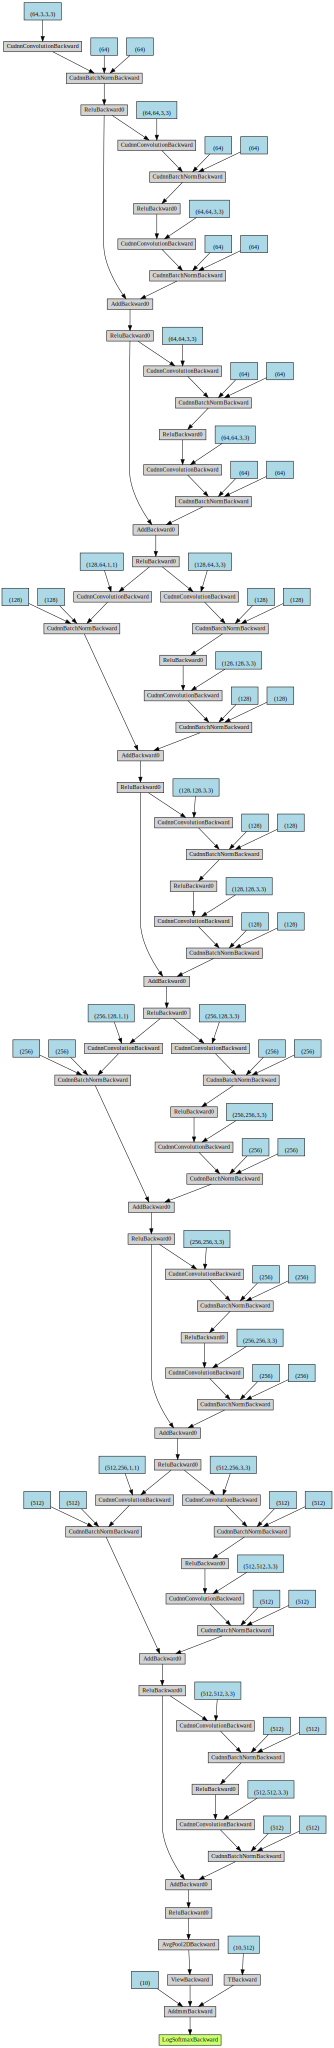

In [18]:
graphical_summary_cifar10(experiment.model)

In [46]:
experiment.run(epochs=1, momentum=0.9, lr=0.01, regularization=None, weight_decay=0.01)

TRAIN : epoch=0 train_loss=0.00545 correct/total=43907/50000 accuracy=87.81: 100%|██████████| 782/782 [00:31<00:00, 25.13it/s]
TEST :  epoch=0 test_loss=0.39814 correct/total=8706/10000 accuracy=87.06: 100%|██████████| 157/157 [00:02<00:00, 53.86it/s]


In [0]:
torch.save(experiment.model.state_dict(), 'model.pth')

In [0]:
_model = ResNet18()
_model.load_state_dict(torch.load('model.pth'))
_model = _model.to(experiment.device)
experiment.model = _model

name_layer_map =  dict(_model.named_modules())

In [0]:
class GradCam():
  def __init__(self, model, data_manager, target_layers):
    self.model = model
    self.data_manager = data_manager
    self.model.eval()
    self.target_layers = target_layers
  
  def get_overlays(self, required_class, one_hot_encoded_class=None):
    
    overlays = {}

    one_hot_encoded_class = one_hot_encoded_class if one_hot_encoded_class else required_class

    # Get labels
    required_label = cifar10_classes.index(required_class)
    one_hot_label = cifar10_classes.index(one_hot_encoded_class)

    # get some random training images for the corresponding label
    dataiter = iter(self.data_manager.test_loader)
    while True:
      images, labels = dataiter.next()
      if required_label in labels:
        images = images[labels == required_label]
        labels = labels[labels == required_label]
        break
    
    # Collect gradients and activations
    handles = []
    activations = {}
    gradients = {}

    def get_activations(layer_name):
        def forward_hook(module, input, output):
            activations[layer_name] = output.detach()
        return forward_hook

    def get_gradients(layer_name):
        def backward_hook(module, grad_in, grad_out):
            gradients[layer_name] = grad_out[0].detach()
        return backward_hook

    # Register hooks to collect gradients and activations
    for layer_name in target_layers:
        if layer_name in name_layer_map:
            forward_handler = name_layer_map[layer_name].register_forward_hook(get_activations(layer_name))
            backward_handler = name_layer_map[layer_name].register_backward_hook(get_gradients(layer_name))
            handles.append(forward_handler)
            handles.append(backward_handler)

    # Collect a sample image and create a tensor
    x = images[0:1, :, :, :].to(experiment.device)
    x = x.requires_grad_(requires_grad=True)
    
    # Forward pass
    self.model.zero_grad()
    logits = _model.logits(x)

    # Get one hot encoded vector for back propogation
    one_hot = torch.zeros_like(logits).to(experiment.device)
    ids = torch.LongTensor([[one_hot_label]]).to(experiment.device)
    one_hot = one_hot.scatter_(1, ids, 1.0)

    # Backward pass
    logits.backward(gradient=one_hot, retain_graph=True)

    # Get overlays for all layers
    for layer_name in target_layers:
      if layer_name in gradients and layer_name in activations:

        # GAP on gradients
        weights = F.adaptive_avg_pool2d(gradients[layer_name], 1)

        # Weight computation
        heat_map = torch.mul(activations[layer_name], weights).sum(dim=1, keepdim=True)

        # Resize, collect and color heat maps
        H, W = 32, 32
        heat_map = F.relu(heat_map)

        _, _, _H, _W = heat_map.shape
        heat_map = heat_map.view((_H, _W))
        _heat_map = heat_map.to('cpu').numpy()

        _heat_map = cv2.resize(_heat_map, (H, W))
        _heat_map = cv2.normalize(_heat_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        _heat_map = cv2.applyColorMap(_heat_map, cv2.COLORMAP_JET)
        _heat_map = cv2.cvtColor(_heat_map, cv2.COLOR_RGB2BGR)

        image = images[0, :, :, :].permute(1, 2, 0).numpy()
        image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        # Create a weight average of the results
        overlay = cv2.addWeighted(_heat_map, 0.25, image, 0.75, 0.0)

        # Add to overlay computation
        overlays[layer_name] = overlay
  
    for handle in handles:
      handle.remove()
  
    return overlays

  def display_heatmaps(self, overlays):
    fig = plt.figure(figsize=(25, 8))
    fig.tight_layout()

    for i, (key, value) in enumerate(overlays.items()):
        ax = fig.add_subplot(1, len(overlays), i + 1)
        plt.imshow(value)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_title(key)

    plt.show()

In [0]:
target_layers = ['layer1.0.bn2', 'layer1.1.bn2', 'layer2.0.bn2', 'layer2.1.bn2', 'layer3.0.bn2', 'layer3.1.bn2', 'layer4.0.bn2', 'layer4.1.bn2']
grad_cam = GradCam(_model, data_manager=data_manager, target_layers=target_layers)

Looking for car in car


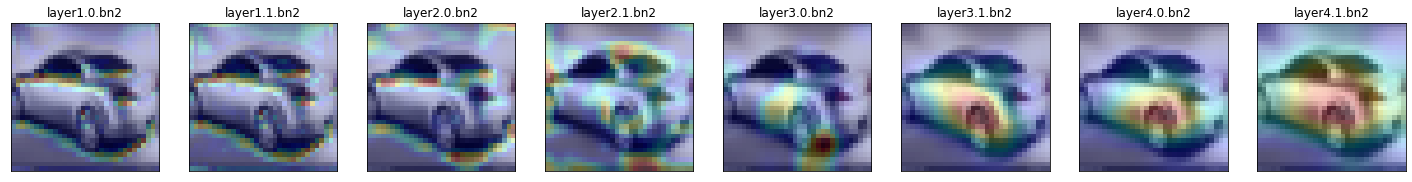

In [383]:
one_hot_encoded_class = 'car'
required_class = 'car'
overlays = grad_cam.get_overlays(required_class=required_class, one_hot_encoded_class=one_hot_encoded_class)
print(f'Looking for {one_hot_encoded_class} in {required_class}')
grad_cam.display_heatmaps(overlays)

In [0]:
required = 'horse'
one_hot_class = 'horse'
required_label = cifar10_classes.index(required)
one_hot_label = cifar10_classes.index(one_hot_class)

In [0]:
# get some random training images for the corresponding label
dataiter = iter(data_manager.test_loader)
while True:
  images, labels = dataiter.next()
  if required_label in labels:
    images = images[labels == required_label]
    labels = labels[labels == required_label]
    break

In [0]:
target_layers = ['layer1.0.bn2', 'layer1.1.bn2', 'layer2.0.bn2', 'layer2.1.bn2', 'layer3.0.bn2', 'layer3.1.bn2', 'layer4.0.bn2', 'layer4.1.bn2']

In [0]:
handles = []
activations = {}
gradients = {}

def get_activations(layer_name):
    def forward_hook(module, input, output):
        activations[layer_name] = output.detach()
    return forward_hook

def get_gradients(layer_name):
    def backward_hook(module, grad_in, grad_out):
        gradients[layer_name] = grad_out[0].detach()
    return backward_hook

for layer_name in target_layers:
    if layer_name in name_layer_map:
        forward_handler = name_layer_map[layer_name].register_forward_hook(get_activations(layer_name))
        backward_handler = name_layer_map[layer_name].register_backward_hook(get_gradients(layer_name))
        handles.append(forward_handler)
        handles.append(backward_handler)

In [0]:
x = images[0:1, :, :, :].to(experiment.device)
x = x.requires_grad_(requires_grad=True)

one_hot = torch.zeros_like(logits).to(experiment.device)
ids = torch.LongTensor([[one_hot_label]]).to(experiment.device)
one_hot = one_hot.scatter_(1, ids, 1.0)

In [0]:
_model.zero_grad()
logits = _model.logits(x)
logits.backward(gradient=one_hot, retain_graph=True)

In [0]:
overlays = {}

In [0]:
for layer_name in target_layers:
  if layer_name in gradients and layer_name in activations:
    weights = F.adaptive_avg_pool2d(gradients[layer_name], 1)
    heat_map = torch.mul(activations[layer_name], weights).sum(dim=1, keepdim=True)

    H, W = 32, 32
    heat_map = F.relu(heat_map)

    _, _, _H, _W = heat_map.shape
    heat_map = heat_map.view((_H, _W))
    _heat_map = heat_map.to('cpu').numpy()

    _heat_map = cv2.resize(_heat_map, (H, W))
    _heat_map = cv2.normalize(_heat_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    _heat_map = cv2.applyColorMap(_heat_map, cv2.COLORMAP_JET)

    image = images[0, :, :, :].permute(1, 2, 0).numpy()
    image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    overlay = cv2.addWeighted(_heat_map, 0.25, image, 0.75, 0.0)

    overlays[layer_name] = overlay

In [328]:
len(overlays)

8

Looking for horse in horse


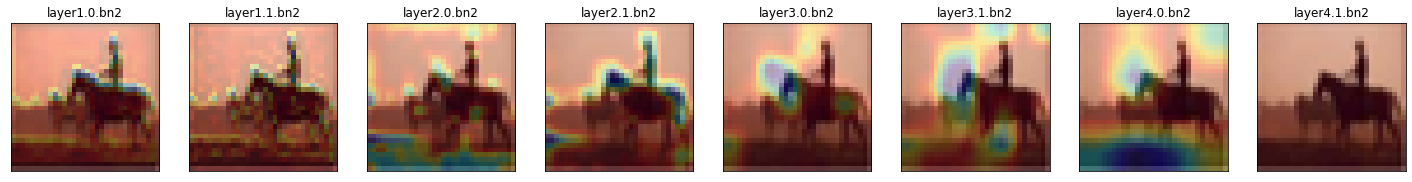

In [339]:
fig = plt.figure(figsize=(25, 8))
print(f'Looking for {one_hot_class} in {required}')
fig.tight_layout()

for i, (key, value) in enumerate(overlays.items()):
    ax = fig.add_subplot(1, len(overlays), i + 1)
    plt.imshow(value)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(key)

plt.show()

In [0]:
for handle in handles:
  handle.remove()

# Result
| Metric | Value |
| - | - |
| _Best train accuracy_| **94.71** |
| _Best test accuracy_| **90.76** |
| _Best epoch number_| **21** |
| _Parameter count_ | **11,173,962** |